<a href="https://colab.research.google.com/github/VasukiElsa/Chat2Visualization/blob/main/chat2Vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installation**

In [1]:
!pip install -q google-generativeai==0.3.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.7/598.7 kB 9.6 MB/s eta 0:00:00


**Imports**

In [3]:
import google.generativeai as genai
import sqlite3

**Version**

In [4]:
genai.__version__

'0.3.1'

**Secret Key**

In [5]:
from google.colab import userdata

genai.configure(api_key = userdata.get('GEMINI_KEY'))

**Configurations**

In [6]:

# Set up the model
generation_config = {
  "temperature": 0.4,
  "top_p": 1,
  "top_k": 32,
  "max_output_tokens": 4096,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  }
]



**Model Instance**

In [7]:
model = genai.GenerativeModel(model_name = "gemini-pro",
                              generation_config = generation_config,
                              safety_settings = safety_settings)

**SQL Query Executer**

In [8]:
def read_sql_query(sql, db):
    conn = sqlite3.connect(db)
    cur = conn.cursor()
    cur.execute(sql)
    rows = cur.fetchall()
    for row in rows:
        print(row)
    conn.close()

In [9]:
read_sql_query('SELECT * FROM fashion_products;',
               "/content/drive/MyDrive/fashion_db.sqlite")

(19, 1, 'Dress', 'Adidas', "Men's Fashion", 40.0, 'Black', 'XL')
(97, 2, 'Shoes', 'H&M', "Women's Fashion", 82.0, 'Black', 'L')
(25, 3, 'Dress', 'Adidas', "Women's Fashion", 44.0, 'Yellow', 'XL')
(57, 4, 'Shoes', 'Zara', "Men's Fashion", 23.0, 'White', 'S')
(79, 5, 'T-shirt', 'Adidas', "Men's Fashion", 79.0, 'Black', 'M')
(98, 6, 'Dress', 'Adidas', "Men's Fashion", 47.0, 'Yellow', 'L')
(16, 7, 'Jeans', 'Gucci', "Men's Fashion", 37.0, 'White', 'XL')
(63, 8, 'Sweater', 'Zara', "Kids' Fashion", 64.0, 'Blue', 'XL')
(96, 9, 'Sweater', 'H&M', "Men's Fashion", 53.0, 'Green', 'XL')
(36, 10, 'T-shirt', 'Zara', "Kids' Fashion", 55.0, 'White', 'XL')


**Define Prompt**

In [10]:
prompt_parts_1 = [
  "You are an expert in converting English questions to SQL code! The SQL database has the name fashion_products and has the following columns - user_id, product_id, product_name, brand, category, price, color, and size.\n\nFor example,\nExample 1 - How many entries of Adidas are present?, the SQL command will be something like this\n``` SELECT COUNT(*) FROM fashion_products WHERE brand = 'Adidas';\n```\n\nExample 2 - How many XL products of Nike are there that have a rating of more than 4?\n```\nSELECT COUNT(*) FROM fashion_products WHERE brand = 'Nike' AND size = 'XL' AND \"Rating\" > 4;\n```\n\nExample 3 - \n```\nSELECT product_name FROM fashion_products WHERE price = (SELECT MAX(price) FROM fashion_products);\n\n Example 4 - Give me the details of most expensive T-shirt\n ``` SELECT * FROM fashion_products WHERE product_name = 'T-shirt' AND price = (SELCT MAX(price) FROM fashion_products WHERE product_name = 'T-shirt');\n```\n\n```Dont include ``` and \\n in the output",
]

In [11]:
question = "Give me the details of the most expensive T-shirt?"

In [12]:
prompt_parts = [prompt_parts_1[0], question]
response = model.generate_content(prompt_parts)
response.text

"SELECT * FROM fashion_products WHERE product_name = 'T-shirt' AND price = (SELECT MAX(price) FROM fashion_products WHERE product_name = 'T-shirt');"

In [13]:
read_sql_query("""
SELECT * FROM fashion_products WHERE product_name = 'T-shirt' AND price = (SELECT MAX(price) FROM fashion_products WHERE product_name = 'T-shirt');
""","/content/drive/MyDrive/fashion_db.sqlite")

(79, 5, 'T-shirt', 'Adidas', "Men's Fashion", 79.0, 'Black', 'M')


**Combine it into Function**

In [20]:
def generate_gemini_response(question, input_prompt):
    prompt_parts = [input_prompt, question]
    response = model.generate_content(prompt_parts)
    output = read_sql_query(response.text, "/content/drive/MyDrive/fashion_db.sqlite")
    return output

In [21]:
generate_gemini_response("How many products of Adidas are there?",
                         prompt_parts_1[0])

(4,)


**Visualization**

[(4, 'Adidas'), (1, 'Gucci'), (2, 'H&M'), (3, 'Zara')]


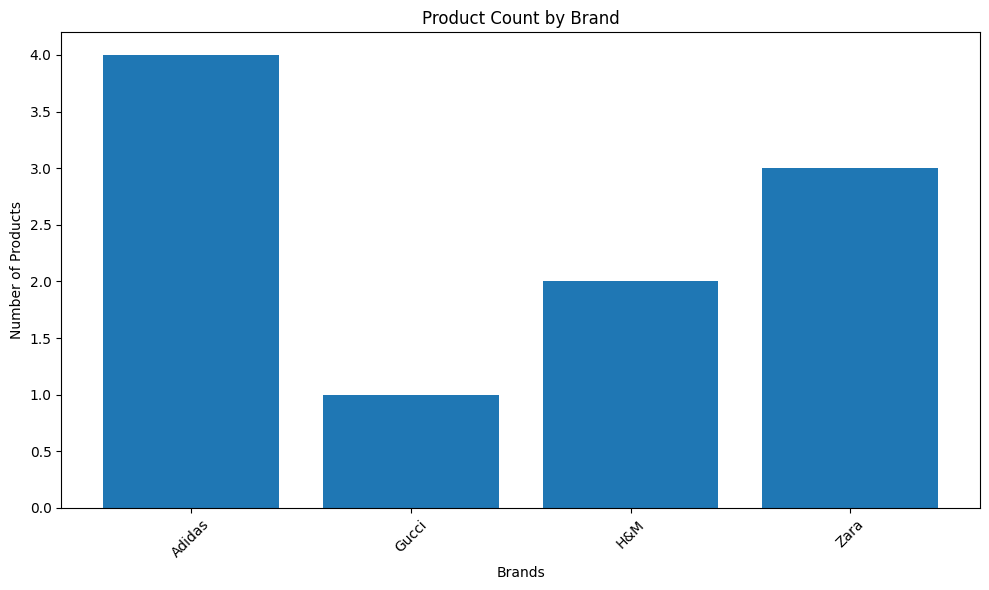

In [24]:
from bs4 import BeautifulSoup
import sqlite3
import matplotlib.pyplot as plt

def generate_visualization(query, db):
    # Connect to the SQLite database
    conn = sqlite3.connect(db)
    c = conn.cursor()

    # Execute the SQL query and fetch the results
    c.execute(query)
    results = c.fetchall()

    print(results)

    # Close the database connection
    conn.close()

    # Prepare the data for visualization
    data = {}
    for row in results:
        brand = row[1]  # Brand is at index 1
        count = row[0]  # Count is at index 0
        data[brand] = count

    # Create the bar chart
    brand = list(data.keys())
    counts = list(data.values())

    plt.figure(figsize=(10, 6))
    plt.bar(brand, counts)
    plt.xlabel("Brands")
    plt.ylabel("Number of Products")
    plt.title("Product Count by Brand")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function with the desired query
generate_visualization("SELECT COUNT(*) as count, brand FROM fashion_products GROUP BY brand", "/content/drive/MyDrive/fashion_db.sqlite")